## Loading data

In [29]:
from pathlib import Path
import numpy as np
import matplotlib.pylab as plt
import h5py
import json
import pickle
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
file_list = []
for file in glob.glob(r"C:\LINHC\VersucheDBs\Trelleborg\2021-01-27-V24\*\*.h5"):
    file_list.append(file)
file_list

['C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\3_Phase_B-E\\20210201_3_Phase_B-E_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\3_Phase_B-E\\20210201_3_Phase_B-E_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\4_Phase_C-F\\20210202_4_Phase_C-F_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\4_Phase_C-F\\20210202_4_Phase_C-F_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\7_Phase_C-F\\20210218_7_Phase_C-F_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\7_Phase_C-F\\20210218_7_Phase_C-F_LEM2.h5',
 'C:\\LINHC\\VersucheDBs

20210218_5_Phase_A-D_LEM1
ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>
Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>
Points:
(1069543,)
shift_opts_freqs_all:
(121, 1069543)


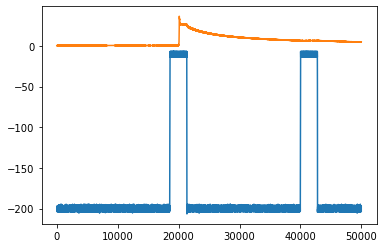

In [3]:
# choose 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM1.h5'
file = file_list[6]
filename = file.split('\\')[-1][:-3]
pklName = './data/shift_opts_freqs_all/' + filename + '.pkl'
shift_opts_freqs_all = pickle.load(open(pklName, 'rb')) 
h51 = h5py.File(file, "r")

print(filename)
print("ATTR:")
print(h51.attrs.keys())
print("Keys:")
print(h51.keys())
print("Points:")
print(h51['t'].shape)
print("shift_opts_freqs_all:")
print(shift_opts_freqs_all.shape)

plt.plot(h51['spd1'][:50000], label = 'spd')
plt.plot(h51['ip1k1'][:50000], label = 'ip1k1')
# plt.legend()

In [4]:
low = np.where(h51['spd1'][:]>-50)[0]
# skip the lsa in first 10000 points because some wierd patterns in speed, 
# check 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM2.h5', 
if filename in ['20210127_Phase_A-D_LEM2']:
    low = low[low>10000]
pos_low = h51['pos1'][low]
low_sep = np.where(np.diff(low)>3000)[0] # check if 3000 fit for all datasets
pos_low_sep = np.split(pos_low,low_sep+1)
Ls = np.append(low[low_sep],low[-1])
Fs = np.append(low[0],low[low_sep+1])
if filename in ["20210218_7_Phase_C-F_LEM1","20210218_7_Phase_C-F_LEM2"]:
    Ls = Ls[:-1]
    Fs = Fs[:-1]

In [5]:
pklName = './data/shift_opts_freqs_all/' + filename + '.pkl'
shift_opts_freqs_all = pickle.load(open(pklName, 'rb'))
shift_opts_freqs_all.shape

(121, 1069543)

In [6]:
N = 100 # ignore first N points
s21 = np.array(h51['S21_P1_LEM1'])
dataset = []
for j in range (121):
    index = np.arange(N,len(h51['t'])) - shift_opts_freqs_all[j,N:].round().astype(int)
    dataset.append(s21[index,j].real)
    dataset.append(s21[index,j].imag)
    
X = np.asarray(dataset).T
y = np.asarray(h51['ip1k1'][N:])
print("X:")
print(X.shape)
print("y:")
print(y.shape)

X:
(1069443, 242)
y:
(1069443,)


In [7]:
h51.close()

## Preprocessing

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

print(X_train.shape)
print(X_val.shape)

(748609, 242)
(106945, 242)


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
scaler.mean_.shape

(242,)

In [17]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val))

# BATCH_SIZE = 64

# train_dataset = train_dataset.batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)
# val_dataset = val_dataset.batch(BATCH_SIZE)

## Hyperparameter fine-tuning

In [34]:
def baseline_model():
  model = keras.Sequential([
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [37]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=64, verbose=0)
kfold = KFold(n_splits=3)
results = cross_val_score(estimator, X_val_scaled, y_val, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (abs(results.mean()), results.std()))

Baseline: 0.53 (0.13) MSE


## Training

### baseline without normalization

In [ ]:
def baseline_model():
  model = keras.Sequential([
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [38]:
NN_baseline = baseline_model()
NN_baseline.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128)               31104     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 39,425
Trainable params: 39,425
Non-trainable params: 0
_________________________________________________________________


In [39]:
# no normalization
%%time
history = NN_baseline.fit(
    X_train, y_train, batch_size = 64
    validation_split=0.2,
    verbose=2, epochs=100)

Epoch 1/100
18716/18716 - 51s - loss: 1.7600 - val_loss: 1.6428
Epoch 2/100
18716/18716 - 47s - loss: 1.5999 - val_loss: 1.5743
Epoch 3/100
18716/18716 - 49s - loss: 1.4936 - val_loss: 1.4038
Epoch 4/100
18716/18716 - 49s - loss: 1.3850 - val_loss: 1.4236
Epoch 5/100
18716/18716 - 50s - loss: 1.2794 - val_loss: 1.2474
Epoch 6/100
18716/18716 - 49s - loss: 1.1877 - val_loss: 1.3868
Epoch 7/100
18716/18716 - 49s - loss: 1.1375 - val_loss: 1.0846
Epoch 8/100
18716/18716 - 49s - loss: 1.0946 - val_loss: 1.1442
Epoch 9/100
18716/18716 - 49s - loss: 1.0483 - val_loss: 0.9751
Epoch 10/100
18716/18716 - 50s - loss: 1.0259 - val_loss: 1.0600
Epoch 11/100
18716/18716 - 50s - loss: 0.9961 - val_loss: 0.9681
Epoch 12/100
18716/18716 - 49s - loss: 0.9739 - val_loss: 1.0354
Epoch 13/100
18716/18716 - 52s - loss: 0.9531 - val_loss: 1.1173
Epoch 14/100
18716/18716 - 57s - loss: 0.9310 - val_loss: 0.9148
Epoch 15/100
18716/18716 - 56s - loss: 0.9140 - val_loss: 1.0021
Epoch 16/100
18716/18716 - 58s - l

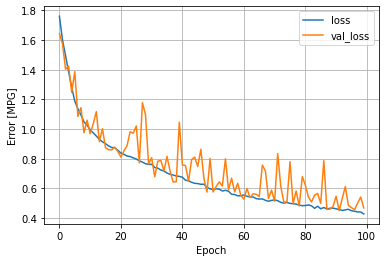

In [42]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [43]:
# Collect the results on the test set
NN_baseline.evaluate(X_test, y_test,verbose = 2)

6685/6685 - 9s - loss: 0.4495


0.44945815205574036

No handles with labels found to put in legend.
<ipython-input-45-56b6ed3391f3>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2, 1, 1)


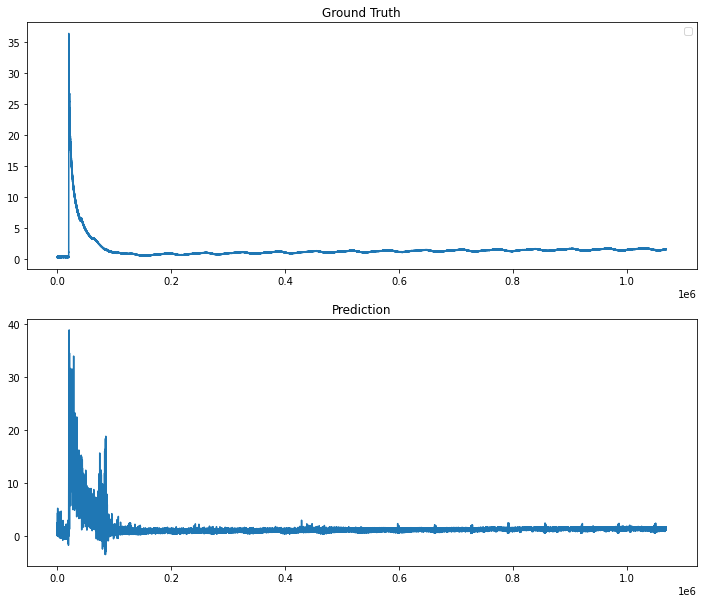

In [45]:
# predictioin vs ground truth
def plot_gt_pre(gt,pre):
    plt.figure(figsize = (12,10))
    plt.subplot(211)
    plt.legend()
    ax1=plt.subplot(2, 1, 1)
    ax2=plt.subplot(212, )
    ax1.plot(gt,label = 'ground truth')
    ax1.title.set_text('Ground Truth')
    ax2.plot(pre,label = 'predict')
    ax2.title.set_text('Prediction')

# X_ = scaler.fit_transform(X)
y_ = NN_baseline.predict(X)
%matplotlib inline
plot_gt_pre(y,y_)

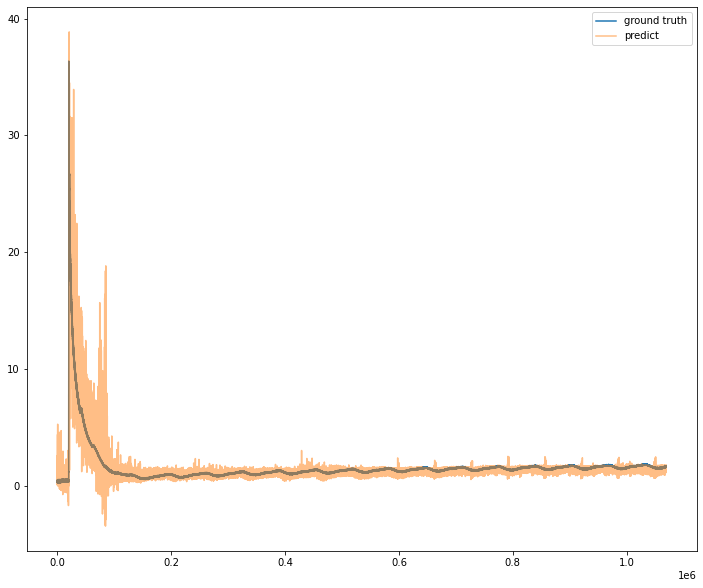

In [48]:
# predictioin vs ground truth in one plot
def plot_gt_pre_overlap(gt,pre):
    %matplotlib inline
    fig = plt.figure(figsize =(12,10))
    ax = fig.add_subplot(111)
    ax.plot(gt,label = 'ground truth')
    ax.plot(pre, label = 'predict', alpha = 0.5)
    plt.legend()
plot_gt_pre_overlap(y,y_)

In [47]:
NN_baseline.save("./models/NN_baseline")

INFO:tensorflow:Assets written to: ./models/NN_baseline\assets


### baseline with normalization

In [ ]:
def baseline_model():
  model = keras.Sequential([
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model